In [202]:
import os

from matplotlib import pyplot as plt
from IPython.display import clear_output
import numpy as np
import pandas as pd
import seaborn as sns
import simdna
from simdna import synthetic
import torch
from tqdm.auto import tqdm

from utils import one_hot_decode
from in_silico_mutagenesis import compute_summary_statistics, generate_wt_mut_batches, write_results
from pyx.one_hot import one_hot
from tf_coop_model import CountsRegressor, IterablePandasDataset
from tf_coop_model import anscombe_transform, run_one_epoch, spearman_rho, pearson_r
from tf_coop_simulation import background_frequency
from tf_coop_simulation import simulate_counts, simulate_oracle_predictions

In [203]:
np.random.seed(42)

# Initialize Model & Load Weights
This step assumes we've trained a counts regression model and have its weights stored in a .pt[h] file somewhere accessible.

In [205]:
n_conv_layers = 3
n_dense_layers = 3
n_outputs = 2
sequence_length = 100
filters = 15
filter_width = 7
dense_layer_width = 30

weights_dir = '../dat/sim/'
weights_fname = 'cnn_counts_predictor.pt'
test_data_fpath = '../dat/sim/test_labels.csv'
raw_simulation_data_fpath = '../dat/sim/test_sequences.simdata'

sequences_col = "sequences"
label_cols = ["labels_exp", "labels_out"]
batch_size = 1000
n_samples = 10

exposure_motif = "GATA_disc1"
outcome_motif = "TAL1_known1"

In [206]:
torch.set_grad_enabled(False)

In [207]:
class Ensemble:
    def __init__(self, model_base_dir, model_fname, model_params, n_reps=5):
        models = []
        for i in range(1, n_reps+1):
            model = CountsRegressor(**params)
            model.load_state_dict(torch.load(os.path.join(model_base_dir, str(i), model_fname)))
            models.append(model)
        self.models = models

    def predict(self, seqs, targets=None):
        preds = {}
        for model in self.models:
            model_preds = model(seqs, targets=targets)
            for key, preds_ in model_preds.items():
                preds.setdefault(key, []).append(preds_.detach().cpu().numpy())
        return {k: np.stack(v) for k, v in preds.items()}

In [168]:
params = {
    "n_conv_layers": n_conv_layers,
    "n_dense_layers": n_dense_layers,
    "n_outputs": n_outputs,
    "sequence_length": sequence_length,
    "filters": filters,
    "filter_width": filter_width,
    "dense_layer_width": dense_layer_width
}
ensemble_model = Ensemble(weights_dir, "cnn_counts_predictor.pt", params)
ensemble_model

# Load Test Data & Generate Predictions
Now we're going to load test data to get some basic metrics about how well our model performs.

In [169]:
test_df = pd.read_csv(test_data_fpath)
test_dataset = IterablePandasDataset(
    test_df, x_cols=sequences_col, y_cols=label_cols, x_transform=one_hot,
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=0
)

# Running Deep MR
So we see that the model predicts both sets of outputs quite well. Now, we want to understand whether the models capture the _interaction effects_ as defined by Finkelstein and Shrikumar et al.

Finkelstein et al define an interaction effect as follows. Let $ s_{GT} $ denote a sequence containing strong matches for both motifs of interest (in our case, the GATA and TAL1 motifs). Then, let $ s_{T} $ denote the result of knocking out the GATA motif from $ s_{GT} $, and $ s_{G} $ the analogous result but for the TAL1 motif. Finally, let $ s_{\emptyset} $ denote the result of knocking out both motifs. Denoting our model as $ f $, the TAL1 motif's per-sequence main effect contribution $ M_T $ is $ f(s_{GT}) - f(s_{G}) $ and GATA's $ M_G $ is $ f(s_{GT}) - f(s_{T}). $ The joint effect contribution is $ J_{G, T} = f(s_{GT}) - f(s_{\emptyset}). $ The interaction effect $ I_{G, T} = J_{G, T} - (M_{G} + M_{T}). $

In Shrikumar et al, all effects are computed in raw counts space. Here, for purposes of making our result relevant to Deep MR, we compute interaction effects in both Anscombe-transformed space and raw counts space but focus on the validity of the former.

In [170]:
original_simulation_df = pd.read_csv(raw_simulation_data_fpath, sep="\t")

In [171]:
merged_data_df = original_simulation_df.merge(test_df, left_on="sequence", right_on="sequences")

In [172]:
both_motifs_df = merged_data_df[(merged_data_df['has_exposure'] == 1) & (merged_data_df['has_outcome'] == 1)]
exposure_motif_df = merged_data_df[merged_data_df['has_exposure'] == 1]
outcome_motif_df = merged_data_df[merged_data_df['has_outcome'] == 1]
neither_motif_df = merged_data_df[
    (merged_data_df['has_exposure'] == 0) & (merged_data_df['has_outcome'] == 0)
]

In [173]:
len(both_motifs_df), len(exposure_motif_df), len(outcome_motif_df), len(neither_motif_df)

(2488, 5029, 4990, 2469)

In [174]:
nts = list(background_frequency.keys())
background_probs = list(background_frequency.values())

def knock_out_motifs(sequence, knock_out_targets):
    knocked_out_sequence = sequence
    for knock_out_target in knock_out_targets:
        replacement_sequence = np.random.choice(
            nts, p=background_probs, size=len(knock_out_target["motif_string"])
        )
        replacement_sequence = "".join(replacement_sequence)
        knock_out_start = knock_out_target["start_position"]
        knock_out_end = knock_out_start + len(knock_out_target["motif_string"])
        knocked_out_sequence = (
            knocked_out_sequence[:knock_out_start] +
            replacement_sequence +
            knocked_out_sequence[knock_out_end:]
        )
    
    assert len(knocked_out_sequence) == len(sequence), (len(knocked_out_sequence), len(sequence))
    return knocked_out_sequence

def generate_knocked_out_sequences(sequences_df, exposure_name="GATA", outcome_name="TAL1"):
    exposure_knock_outs = []
    outcome_knock_outs = []
    both_knock_outs = []
    for row in sequences_df.iterrows():
        sequence = row[1]['sequence']
        embedding_info = [embedding.split("_") for embedding in row[1]["embeddings"].split(",")]
        knock_out_targets = {}
        for embedding in embedding_info:
            knock_out_target = {}
            knock_out_target["start_position"] = int(embedding[0].split("-")[1]) # format 'pos-<start position>'
            knock_out_target["motif_type"] = embedding[1]
            knock_out_target["motif_string"] = embedding[2].split("-")[1] # format '<motif name>-<string>'
            assert embedding[1] in (exposure_name, outcome_name)
            knock_out_targets[embedding[1]] = knock_out_target
            
        assert len(knock_out_targets) == 2, len(knock_out_targets) 

        exposure_knock_outs.append(knock_out_motifs(sequence, [knock_out_targets[exposure_name]]))
        outcome_knock_outs.append(knock_out_motifs(sequence, [knock_out_targets[outcome_name]]))
        both_knock_outs.append(knock_out_motifs(sequence, knock_out_targets.values()))
    return exposure_knock_outs, outcome_knock_outs, both_knock_outs

In [175]:
exposure_knock_outs, outcome_knock_outs, both_knock_outs = generate_knocked_out_sequences(both_motifs_df)
both_motifs_df['sequence_exp_knock_out'] = exposure_knock_outs
both_motifs_df['sequence_out_knock_out'] = outcome_knock_outs
both_motifs_df['sequence_both_knock_out'] = both_knock_outs
clear_output();

In [176]:
both_motifs_dataset = IterablePandasDataset(
    both_motifs_df, x_cols=sequences_col, y_cols=label_cols, x_transform=one_hot,
)
both_motifs_data_loader = torch.utils.data.DataLoader(
    both_motifs_dataset, batch_size=batch_size, num_workers=0
)

In [177]:

def mutate_and_predict(model, sample_dataset):
    preds = {}
    all_muts = []
    for seq, label in tqdm(sample_dataset):
        muts = generate_wt_mut_batches(seq, seq.shape[0] * seq.shape[1]).squeeze()
        muts = muts.transpose(0, 1, 2)
        muts = torch.from_numpy(muts)
        label = torch.from_numpy(label)
        preds_ = model.predict(muts, targets=label)['predictions']
        exposure_preds = preds_[:, :, 0]
        outcome_preds = preds_[:, :, 1]
        preds.setdefault('exposure', []).append(exposure_preds)
        preds.setdefault('outcome', []).append(outcome_preds)
        all_muts.append(muts.detach().cpu().numpy())
    return all_muts, preds

In [178]:
both_motifs_sample_dataset, _ = torch.utils.data.random_split(
    both_motifs_dataset, (n_samples, len(both_motifs_dataset) - n_samples)
)
both_motifs_sample_seqs = [x for x, y in both_motifs_dataset]

In [179]:
muts, preds = mutate_and_predict(ensemble_model, both_motifs_sample_dataset)
sample_seqs = [seq for seq, label in both_motifs_sample_dataset]

/home/stephenmalina/anaconda3/envs/deepmr/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([400, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [180]:
exposure_col = "exposure"
outcome_col = "outcome"

formatted_preds = np.stack((preds[exposure_col], preds[outcome_col]))
n_features, n_seqs, n_reps, n_variants = formatted_preds.shape
formatted_preds = formatted_preds.transpose(2, 1, 3, 0)
formatted_preds = formatted_preds.reshape(n_reps, n_seqs, 4, -1, n_features)

means, mean_diffs, stderrs = compute_summary_statistics(formatted_preds, np.array(sample_seqs))

# results_fname = f'GATA_TAL1_effect_sizes.csv'
# results_fpath = os.path.join('../dat/sim', results_fname)
# write_results(results_fpath, mean_diffs, stderrs)
# print(results_fpath)

/home/stephenmalina/dev/an1lam/deepmr/src/in_silico_mutagenesis.py:168: RuntimeWarning: invalid value encountered in sqrt
  stderrs = np.sqrt(ref_vars + mut_vars - 2 * covs)


0.642025297808766


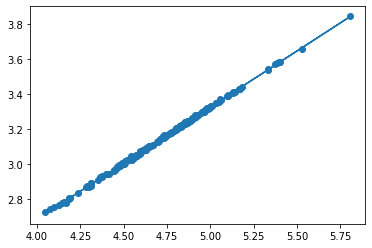

In [181]:
plt.cla()
seq_idxs = np.array(sample_seqs).astype(np.bool)
mut_means = means[~seq_idxs].reshape(n_seqs, 3, 100, -1)
x = (mut_means[5, :, :, 0]).flatten()
y = (mut_means[5, :, :, 1]).flatten()
m, b = np.polyfit(x, y, 1)
plt.scatter(x, y)
plt.plot(x, m*x + b)
print(m)